# Example 5: Cell Death Signal

For the cell death analysis we are using PI stain to indicate the viability signal. For multi-cell interaction imaging, however, if both cell type dies we may hardly identify the signal is originated from which cell. To overcome the issue we suggest:

1. Channel weighted merging (ref: [example_1.ipynb](./example_1.ipynb))
2. Track cells with the segmentation mask from the merged image
3. Perform cross cell channel pixel correlation (pixelwise co-localization).
4. Identify death signal from the correlation map

Following demonstrates workflow to generate the csv file output.

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure
import pandas as pd

## Load Image Files

In [2]:
CANCER_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma/ch0/*.tif"
TCELL_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma/ch2/*.tif"

PI_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma/ch1/*.tif"

CANCER_CORR_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_cc/cancer/*.tif"
TCELL_CORR_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_cc/tcell/*.tif"

CANCER_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_channel_merged_masks/cancer/*.tif"
TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_channel_merged_masks/tcell/*.tif"

In [3]:
# default chunk size: 1 image
image_cancer = dask_image.imread.imread(CANCER_IMAGE_PATH_PATTERN)
image_tcell = dask_image.imread.imread(TCELL_IMAGE_PATH_PATTERN)

pi_image = dask_image.imread.imread(PI_IMAGE_PATH_PATTERN)

cancer_corr = dask_image.imread.imread(CANCER_CORR_PATH_PATTERN)
tcell_corr = dask_image.imread.imread(TCELL_CORR_PATH_PATTERN)

label_cancer = dask_image.imread.imread(CANCER_LABEL_PATH_PATTERN)
label_tcell = dask_image.imread.imread(TCELL_LABEL_PATH_PATTERN)

image_cancer

dask.array<_map_read_frame, shape=(2000, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

In [78]:
FRAMES = 500 # define number of frames to perform killing analysis

In [79]:
# convert segmentation mask to trackpy style array
features = {}
features_pi = {}
features_corr = {}

# note that pyCyto works in XYT dim order but dask/tiff is in TYX, need to transpose the array
# TODO: pixel spacing
features["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=image_cancer[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer")
features["tcell"] = label_to_sparse(label=label_tcell[:FRAMES,:,:].T,image=image_tcell[:FRAMES,:,:].T,spacing=[1,1],channel_name="tcell")

features_pi["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=pi_image[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer_pi")
features_pi["tcell"] = label_to_sparse(label=label_tcell[:FRAMES,:,:].T,image=pi_image[:FRAMES,:,:].T,spacing=[1,1],channel_name="tcell_pi")

features_corr["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=cancer_corr[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer_corr")
features_corr["tcell"] = label_to_sparse(label=label_tcell[:FRAMES,:,:].T,image=tcell_corr[:FRAMES,:,:].T,spacing=[1,1],channel_name="tcell_corr")


100%|██████████| 500/500 [03:22<00:00,  2.48it/s]


## Concatenate Signals from Different Images

In [80]:
features["cancer"][["pi_mean","pi_median", "pi_std"]] = features_pi["cancer"][["mean","median", "sd"]] 
features["cancer"][["corr_mean","corr_median", "corr_std"]] = features_corr["cancer"][["mean","median", "sd"]] 

features["tcell"][["pi_mean","pi_median", "pi_std"]] = features_pi["tcell"][["mean","median", "sd"]] 
features["tcell"][["corr_mean","corr_median", "corr_std"]] = features_corr["tcell"][["mean","median", "sd"]] 

## Load Tracks 

In [81]:
# Load tracking file and merge with the contact analysis table
TRACK_PATH = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/tracks_param_00000.csv"

tracks_df_cancer = pd.read_csv(TRACK_PATH)
tracks_df_cancer = tracks_df_cancer.sort_values(by=["t"])
tracks_df_cancer = tracks_df_cancer[tracks_df_cancer["t"] < FRAMES]
tracks_df_cancer

,track_id,t,y,x,id,parent_track_id,parent_id
0,1,0,4.0,47.0,1000015,-1,-1
383285,1088,0,823.0,884.0,1008155,-1,-1
383165,1087,0,815.0,934.0,1008152,-1,-1
382805,1086,0,855.0,977.0,1008149,-1,-1
382538,1085,0,775.0,969.0,1008147,-1,-1
...,...,...,...,...,...,...,...
1074858,7695,499,233.0,500.0,500003058,-1,499003219
946105,6300,499,236.0,856.0,500002738,-1,499002555
813910,4797,499,719.0,497.0,500008178,-1,499008024
1055329,7492,499,539.0,931.0,500006410,-1,499006559


In [82]:
# Load tracking file and merge with the contact analysis table
TRACK_PATH = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/tracks_param_00000.csv"

tracks_df_tcell = pd.read_csv(TRACK_PATH)
tracks_df_tcell = tracks_df_tcell.sort_values(by=["t"])
tracks_df_tcell = tracks_df_tcell[tracks_df_tcell["t"] < FRAMES]
tracks_df_tcell

,track_id,t,y,x,id,parent_track_id,parent_id
0,1,0,1.0,21.0,1000002,-1,-1
1852152,10456,0,444.0,83.0,1017364,-1,-1
1852146,10455,0,443.0,521.0,1017357,-1,-1
1851890,10454,0,442.0,205.0,1017354,-1,-1
2489838,14040,0,725.0,289.0,1023456,-1,-1
...,...,...,...,...,...,...,...
8134732,85191,499,684.0,757.0,500023530,85189,499023850
5068705,41058,499,914.0,358.0,500032921,-1,499032837
6129560,56179,499,99.0,720.0,500004050,-1,499004594
8184683,85922,499,117.0,209.0,500001421,-1,499001577


In [83]:
from sklearn.neighbors import KDTree

tcell_df = features["tcell"]

# iterate over frames
tcell_df_remapped = []
for t in range(FRAMES):
    tcell_t_df = tcell_df[tcell_df["frame"]==t]
    tracks_t_df = tracks_df_tcell[tracks_df_tcell["t"]==t]
    points_tcell = tcell_t_df[["y","x"]].values
    points_ultrack = tracks_t_df[["x","y"]].values

    # build KD-Tree for each point in ultrack df
    kdtree_ultrack = KDTree(points_ultrack)

    # query closest point for each point in t cell df
    dist, indices = kdtree_ultrack.query(points_tcell,k=1)

    dist = [d[0] for d in dist]
    indices = [i[0] for i in indices]

    remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
    remapped_track_ids["dist_from_ultrack"] = dist

    tcell_t_df.reset_index(drop=True,inplace=True)
    remapped_track_ids.reset_index(drop=True,inplace=True)
    tcell_t_df_remapped = pd.concat([tcell_t_df,remapped_track_ids],axis=1)

    tcell_df_remapped.append(tcell_t_df_remapped)

tcell_df_remapped = pd.concat(tcell_df_remapped)

track_pair_counts = tcell_df_remapped.groupby(["frame","track_id"]).size().reset_index(name="count")
filtered_rows = track_pair_counts[track_pair_counts['count'] != 1]

sorted_df = tcell_df_remapped.sort_values(by=["frame","track_id","dist_from_ultrack"])
sorted_df = sorted_df.drop_duplicates(subset=["frame","track_id"], keep="first")

sorted_df["tracked frames"] = sorted_df['frame'].groupby(sorted_df['track_id']).transform('count')
sorted_df['tracked length'] = sorted_df.groupby('track_id')['frame'].transform("max") - sorted_df.groupby('track_id')['frame'].transform("min") +1 

# filter out short tracks
min_track_length = 20
tracks_df_filtered_tcell = sorted_df[sorted_df["tracked length"] > min_track_length]

# filter by tracked average cell size
mean_transform = lambda x: x.mean()
tracks_df_filtered_tcell['mean tracked cell size'] = tracks_df_filtered_tcell.groupby("track_id")["size"].transform(mean_transform)

area_percentiles = tracks_df_filtered_tcell.sort_values("track_id")['mean tracked cell size'].quantile(0.95)

# filter out the cells with average area larger than threshold
tracks_df_filtered_tcell = tracks_df_filtered_tcell[tracks_df_filtered_tcell["mean tracked cell size"]<area_percentiles]
tracks_df_filtered_tcell

/tmp/ipykernel_542838/1661955409.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered_tcell['mean tracked cell size'] = tracks_df_filtered_tcell.groupby("track_id")["size"].transform(mean_transform)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,44.300528,32780.045455,32905.679688,2.951630,1,1000002,0.181818,162,162,22.043210
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,445.091303,32858.754098,32905.679688,123.740619,4,1000016,2.544339,142,145,59.725352
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,54.361198,32763.733333,32650.320312,11.338948,6,1000019,0.307318,134,134,53.768657
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,93.777697,32769.305263,32650.320312,11.074288,9,1000021,0.357895,57,57,46.614035
9495,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,...,271.456578,33130.250000,33161.039062,155.747730,10,1000024,0.500000,25,28,35.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,4865508,614.850000,972.175000,969,612,7,7,972.175000,614.850000,969.0,...,38.971883,32776.300000,32886.412109,2.015326,89912,500034893,0.230489,21,21,38.666667
5581,4866809,362.235294,996.058824,993,360,7,6,996.058824,362.235294,993.0,...,308.899647,32772.558824,32886.412109,13.387446,89921,500034976,0.242536,21,21,29.523810
8170,4869398,146.666667,980.583333,978,145,6,5,980.583333,146.666667,978.0,...,60.652595,32777.125000,32886.412109,3.530150,89923,500035003,0.533594,21,21,22.333333
6142,4867370,932.281250,988.125000,984,929,8,7,988.125000,932.281250,984.0,...,58.606809,32778.968750,32886.412109,3.393394,89924,500035169,0.307777,13,21,57.846154


In [84]:
from sklearn.neighbors import KDTree

cancer_df = features["cancer"]

# iterate over frames
cancer_df_remapped = []
for t in range(FRAMES):
    cancer_t_df = cancer_df[cancer_df["frame"]==t]
    tracks_t_df = tracks_df_cancer[tracks_df_cancer["t"]==t]
    points_cancer = cancer_t_df[["y","x"]].values
    points_ultrack = tracks_t_df[["x","y"]].values

    # build KD-Tree for each point in ultrack df
    kdtree_ultrack = KDTree(points_ultrack)

    # query closest point for each point in t cell df
    dist, indices = kdtree_ultrack.query(points_cancer,k=1)

    dist = [d[0] for d in dist]
    indices = [i[0] for i in indices]

    remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
    remapped_track_ids["dist_from_ultrack"] = dist

    cancer_t_df.reset_index(drop=True,inplace=True)
    remapped_track_ids.reset_index(drop=True,inplace=True)
    cancer_t_df_remapped = pd.concat([cancer_t_df,remapped_track_ids],axis=1)

    cancer_df_remapped.append(cancer_t_df_remapped)

cancer_df_remapped = pd.concat(cancer_df_remapped)

track_pair_counts = cancer_df_remapped.groupby(["frame","track_id"]).size().reset_index(name="count")
filtered_rows = track_pair_counts[track_pair_counts['count'] != 1]

sorted_df_cancer = cancer_df_remapped.sort_values(by=["frame","track_id","dist_from_ultrack"])
sorted_df_cancer = sorted_df_cancer.drop_duplicates(subset=["frame","track_id"], keep="first")

sorted_df_cancer["tracked frames"] = sorted_df_cancer['frame'].groupby(sorted_df_cancer['track_id']).transform('count')
sorted_df_cancer['tracked length'] = sorted_df_cancer.groupby('track_id')['frame'].transform("max") - sorted_df_cancer.groupby('track_id')['frame'].transform("min") +1 

# filter out short tracks
min_track_length = 20
tracks_df_filtered_cancer = sorted_df_cancer[sorted_df_cancer["tracked length"] > min_track_length]

# filter by tracked average cell size
mean_transform = lambda x: x.mean()
tracks_df_filtered_cancer['mean tracked cell size'] = tracks_df_filtered_cancer.groupby("track_id")["size"].transform(mean_transform)

area_percentiles = tracks_df_filtered_cancer.sort_values("track_id")['mean tracked cell size'].quantile(0.95)

# filter out the cells with average area larger than threshold
tracks_df_filtered_cancer = tracks_df_filtered_cancer[tracks_df_filtered_cancer["mean tracked cell size"]<area_percentiles]
tracks_df_filtered_cancer

/tmp/ipykernel_542838/977165235.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered_cancer['mean tracked cell size'] = tracks_df_filtered_cancer.groupby("track_id")["size"].transform(mean_transform)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
749,750,47.236686,4.218935,0,38,12,22,4.218935,47.236686,0.0,...,405.286805,32835.147929,32650.320312,112.348398,1,1000015,0.322417,495,500,191.151515
337,338,39.313846,20.772308,11,30,21,20,20.772308,39.313846,11.0,...,173.434119,32757.003077,32650.320312,13.057210,2,1000016,0.387741,250,250,257.560000
643,644,68.674641,6.401914,0,61,16,17,6.401914,68.674641,0.0,...,109.183210,32737.842105,32650.320312,46.478686,3,1000065,0.517101,267,268,182.782772
442,443,103.872792,7.696113,0,94,17,20,7.696113,103.872792,0.0,...,386.760344,32876.250883,32905.679688,137.732668,4,1000067,0.329438,68,72,323.205882
533,534,99.112000,20.592000,14,88,16,26,20.592000,99.112000,14.0,...,533.552024,32887.816000,32905.679688,179.961258,5,1000068,0.423093,101,120,291.039604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,632766,981.019139,516.332536,509,965,17,32,516.332536,981.019139,509.0,...,747.011440,32912.569378,32886.412109,244.130368,7575,500006577,0.667738,19,21,383.315789
533,633107,938.192913,602.968504,593,930,19,20,602.968504,938.192913,593.0,...,691.389475,32889.748031,32886.412109,185.060613,7578,500007288,0.195468,21,21,301.095238
701,633275,267.489796,843.204082,836,258,16,18,843.204082,267.489796,836.0,...,951.420646,32960.739796,32886.412109,154.026999,7587,500009127,0.549507,21,21,166.619048
330,632904,297.868421,799.143275,790,287,20,22,799.143275,297.868421,790.0,...,587.426646,32854.760234,32886.412109,115.344319,7590,500009151,1.873906,21,21,431.000000


In [85]:
# save tracks
tracks_df_filtered_tcell.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/tcell_tracks_filtered.csv")
tracks_df_filtered_cancer.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/cancer_tracks_filtered.csv")

In [86]:
tracks_df_filtered_tcell

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
9160,9161,21.000000,1.181818,0,18,4,7,1.181818,21.000000,0.0,...,44.300528,32780.045455,32905.679688,2.951630,1,1000002,0.181818,162,162,22.043210
419,420,46.549180,6.090164,0,40,14,13,6.090164,46.549180,0.0,...,445.091303,32858.754098,32905.679688,123.740619,4,1000016,2.544339,142,145,59.725352
1934,1935,61.300000,11.933333,8,57,9,9,11.933333,61.300000,8.0,...,54.361198,32763.733333,32650.320312,11.338948,6,1000019,0.307318,134,134,53.768657
699,700,57.642105,5.000000,0,53,13,11,5.000000,57.642105,0.0,...,93.777697,32769.305263,32650.320312,11.074288,9,1000021,0.357895,57,57,46.614035
9495,9496,95.000000,1.500000,0,93,4,5,1.500000,95.000000,0.0,...,271.456578,33130.250000,33161.039062,155.747730,10,1000024,0.500000,25,28,35.440000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4280,4865508,614.850000,972.175000,969,612,7,7,972.175000,614.850000,969.0,...,38.971883,32776.300000,32886.412109,2.015326,89912,500034893,0.230489,21,21,38.666667
5581,4866809,362.235294,996.058824,993,360,7,6,996.058824,362.235294,993.0,...,308.899647,32772.558824,32886.412109,13.387446,89921,500034976,0.242536,21,21,29.523810
8170,4869398,146.666667,980.583333,978,145,6,5,980.583333,146.666667,978.0,...,60.652595,32777.125000,32886.412109,3.530150,89923,500035003,0.533594,21,21,22.333333
6142,4867370,932.281250,988.125000,984,929,8,7,988.125000,932.281250,984.0,...,58.606809,32778.968750,32886.412109,3.393394,89924,500035169,0.307777,13,21,57.846154


In [87]:
tracks_df_filtered_tcell.columns

Index(['label', 'y', 'x', 'bbox_xstart', 'bbox_ystart', 'bbox_xsize',
       'bbox_ysize', 'i', 'j', 'bbox_istart', 'bbox_jstart', 'bbox_isize',
       'bbox_jsize', 'size', 'elongation', 'flatness', 'roundness',
       'feret_diameter', 'feret_radius', 'perimeter', 'mass', 'mean', 'median',
       'sd', 'frame', 'channel', 'alive', 'pi_mean', 'pi_median', 'pi_std',
       'corr_mean', 'corr_median', 'corr_std', 'track_id', 'id',
       'dist_from_ultrack', 'tracked frames', 'tracked length',
       'mean tracked cell size'],
      dtype='object')

In [88]:
features_corr["tcell"]

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive
0,1,670.849246,390.738693,378,655,25,35,390.738693,670.849246,378.0,...,34.132096,17.066048,98.907157,20072241.0,33621.844221,33161.039062,1302.823913,0,tcell_corr,NaN
1,2,132.066532,630.483871,618,116,24,32,630.483871,132.066532,618.0,...,31.400637,15.700318,90.537283,17696583.0,35678.594758,34948.554688,3220.117246,0,tcell_corr,NaN
2,3,274.956790,865.415638,851,264,30,23,865.415638,274.956790,851.0,...,30.675723,15.337862,84.293566,15967940.0,32855.843621,32650.320312,290.928950,0,tcell_corr,NaN
3,4,691.069930,680.552448,667,675,25,28,680.552448,691.069930,667.0,...,30.232433,15.116216,82.167409,14486015.0,33766.934732,33161.039062,1521.887311,0,tcell_corr,NaN
4,5,659.125874,729.431235,717,648,29,22,729.431235,659.125874,717.0,...,31.304952,15.652476,84.388851,14955096.0,34860.363636,33927.117188,2001.935140,0,tcell_corr,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870517,4870518,84.600000,910.400000,909,83,4,4,910.400000,84.600000,909.0,...,4.242641,2.121320,13.502870,491637.0,32775.800000,32886.412109,2.366432,499,tcell_corr,NaN
4870518,4870519,328.600000,920.600000,919,327,4,4,920.600000,328.600000,919.0,...,4.242641,2.121320,13.502870,491616.0,32774.400000,32886.412109,2.261479,499,tcell_corr,NaN
4870519,4870520,787.400000,971.600000,970,786,4,4,971.600000,787.400000,970.0,...,4.242641,2.121320,13.502870,491662.0,32777.466667,32886.412109,2.614975,499,tcell_corr,NaN
4870520,4870521,790.400000,987.600000,986,789,4,4,987.600000,790.400000,986.0,...,4.242641,2.121320,13.502870,491663.0,32777.533333,32886.412109,2.386470,499,tcell_corr,NaN


## Plot Cell Signals Overtime

(-1000.0, 1000.0)

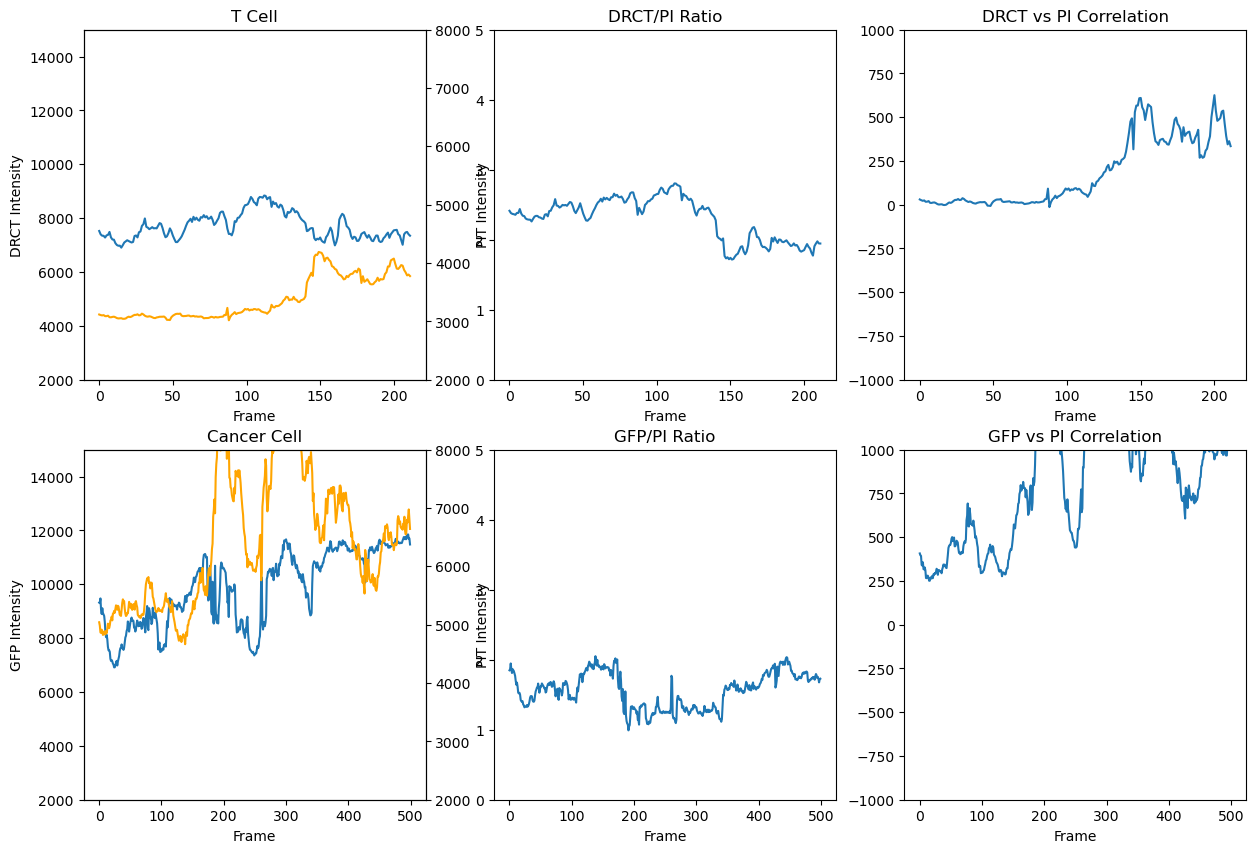

In [350]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs=axs.ravel()

# isolate one cell
TRACK_ID_TCELL = 37

single_tcell_df = tracks_df_filtered_tcell.loc[tracks_df_filtered_tcell["track_id"]==TRACK_ID_TCELL]
single_tcell_df = single_tcell_df.sort_values(by=["frame"])

# isolate one cell
TRACK_ID_CANCER = 74

single_cancer_df = tracks_df_filtered_cancer.loc[tracks_df_filtered_cancer["track_id"]==TRACK_ID_CANCER]
single_cancer_df = single_cancer_df.sort_values(by=["frame"])

# t cell signal
axs[0].plot(single_tcell_df["frame"],single_tcell_df["mean"],label="DRCT")
axs_ = axs[0].twinx()
axs_.plot(single_tcell_df["frame"],single_tcell_df["pi_mean"],label="PI",color="orange")
axs[0].set_title("T Cell")
axs[0].set_xlabel("Frame")
axs[0].set_ylabel("DRCT Intensity")
axs[0].set_ylim([2000,15000])
axs_.set_ylabel("PIT Intensity")
axs_.set_ylim([2000,8000])

axs[1].plot(single_tcell_df["frame"],single_tcell_df["mean"]/single_tcell_df["pi_mean"])
axs[1].set_title("DRCT/PI Ratio")
axs[1].set_xlabel("Frame")
axs[1].set_ylim([0,5])

axs[2].plot(single_tcell_df["frame"],single_tcell_df["corr_mean"]-(2**16-1)//2)
axs[2].set_title("DRCT vs PI Correlation")
axs[2].set_xlabel("Frame")
axs[2].set_ylim([-1000,1000])

# cancer signal
axs[3].plot(single_cancer_df["frame"],single_cancer_df["mean"],label="GFP")
axs_ = axs[3].twinx()
axs_.plot(single_cancer_df["frame"],single_cancer_df["pi_mean"],label="PI",color="orange")
axs[3].set_title("Cancer Cell")
axs[3].set_xlabel("Frame")
axs[3].set_ylabel("GFP Intensity")
axs[3].set_ylim([2000,15000])
axs_.set_ylabel("PIT Intensity")
axs_.set_ylim([2000,8000])

axs[4].plot(single_cancer_df["frame"],single_cancer_df["mean"]/single_cancer_df["pi_mean"])
axs[4].set_title("GFP/PI Ratio")
axs[4].set_xlabel("Frame")
axs[4].set_ylim([0,5])

axs[5].plot(single_cancer_df["frame"],single_cancer_df["corr_mean"]-(2**16-1)//2)
axs[5].set_title("GFP vs PI Correlation")
axs[5].set_xlabel("Frame")
axs[5].set_ylim([-1000,1000])